In [1]:
import PIL
PIL.__version__

'7.1.2'

In [2]:
!pip uninstall -y Pillow
!pip install -Iv Pillow==5.3.0
;

Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
Created temporary directory: /tmp/pip-ephem-wheel-cache-8cruccau
Created temporary directory: /tmp/pip-req-tracker-u6t7uh_s
Created requirements tracker '/tmp/pip-req-tracker-u6t7uh_s'
Created temporary directory: /tmp/pip-install-zwx4f8_f
1 location(s) to search for versions of Pillow:
* https://pypi.org/simple/pillow/
Getting page https://pypi.org/simple/pillow/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/pillow/" in the cache
Request header has "max_age" as 0, cache bypassed
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/pillow/ HTTP/1.1" 200 187888
Updating cache with response from "https://pypi.org/simple/pillow/"
Caching due to etag
Analyzing links from page https://pypi.org/simple/pillow/
  Found link https://files.pythonhosted.org/packages/72/e6/692512c5d9dc97f83a91f8a75806e0b9e910ebd8d6b0b3d6ca9a249c1e26/Pillow-1.0.tar.gz#sha256=be8643522995b496

''

---


**ВНИМАНИЕ: На этом этапе обязательно перезагрузить рантайм (Runtime -> Restart Runtime). Иначе версия 5.3.0 не будет загружена в рантайм.**

После перезапуска рантайма следует продолжить исполнять ячейки далее.

---



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision;

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [2]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).




---

**ВНИМАНИЕ: скачайте датасет с каггла и положите его в корень своего гугл диска!**

---



In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import pathlib
from pathlib import Path

In [6]:
TRAIN_DIR = Path('./train/simpsons_dataset')
TEST_DIR = Path('./testset/testset')

In [9]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [10]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun May 16 04:44:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
import random 
SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

CUDA_LAUNCH_BLOCKING=1

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

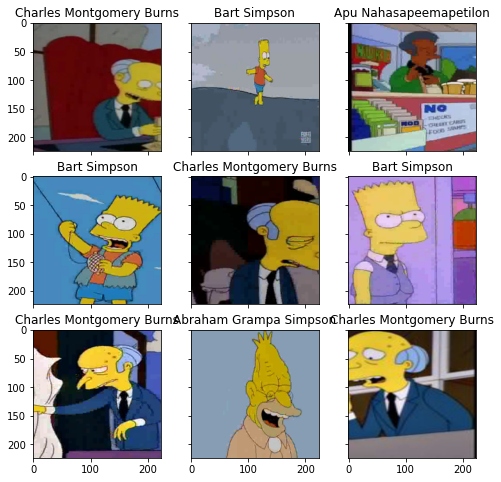

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [16]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [17]:
#загружает данные из трейнлоадера, прогоняет через сеть и считает функцию потерь
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) #перенос тензоров на видеокарту
        labels = labels.to(DEVICE)
        optimizer.zero_grad() #обнуляем градиенты, чтобы они не накапливались

        outputs = model(inputs) #прогоняем данные из трейнлоадера чеез нашу сеть (модель). интересно, почему не model.forward(inputs)?
        loss = criterion(outputs, labels) #считаем лосс
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1) #все, что больше 1, приводим к 1
        running_loss += loss.item() * inputs.size(0) #непонятно, как работает .size(0)
        running_corrects += torch.sum(preds == labels.data) #если предсказание совпадает с ответом, увеличиваем на 1 running_corrects
        processed_data += inputs.size(0) 
              
    train_loss = running_loss / processed_data #потери на трейне
    train_acc = running_corrects.cpu().numpy() / processed_data #точность на трейне
    return train_loss, train_acc

In [18]:
#загружаем валидационные данные, прогоняем через модель, не считая градиенты
#не используем оптимайзер
#считаем потери
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
#загружаем файлы, формируем лоадеры. 
#прогоняем трейн через функцию fit_epoch, валид - через eval_epoch. получаем значения лосса и точности 
#на трейновой и валидационной выборках. загружаем их в список history

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad(): #без градиентов
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))
print(n_classes)
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

42
we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_

Запустим обучение сети.

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.620995302178752


epoch:  50%|█████     | 1/2 [02:56<02:56, 176.64s/it]


Epoch 001 train_loss: 2.6210     val_loss 1.9842 train_acc 0.2630 val_acc 0.4549
loss 1.5929356344460424


epoch: 100%|██████████| 2/2 [05:52<00:00, 176.30s/it]


Epoch 002 train_loss: 1.5929     val_loss 1.4867 train_acc 0.5593 val_acc 0.6003


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

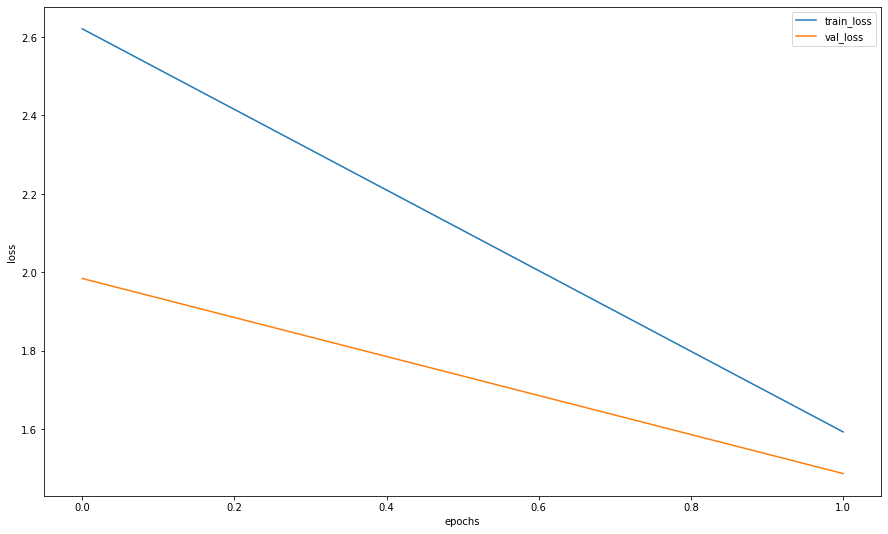

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

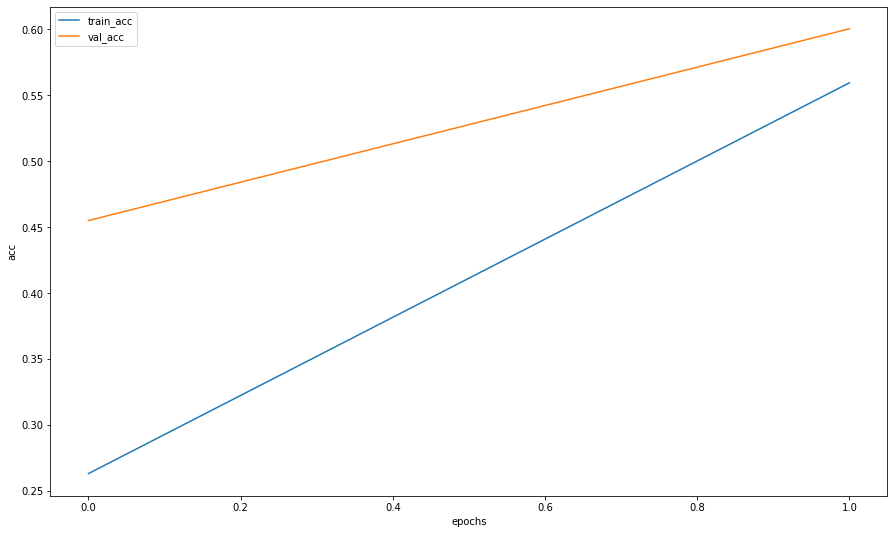

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

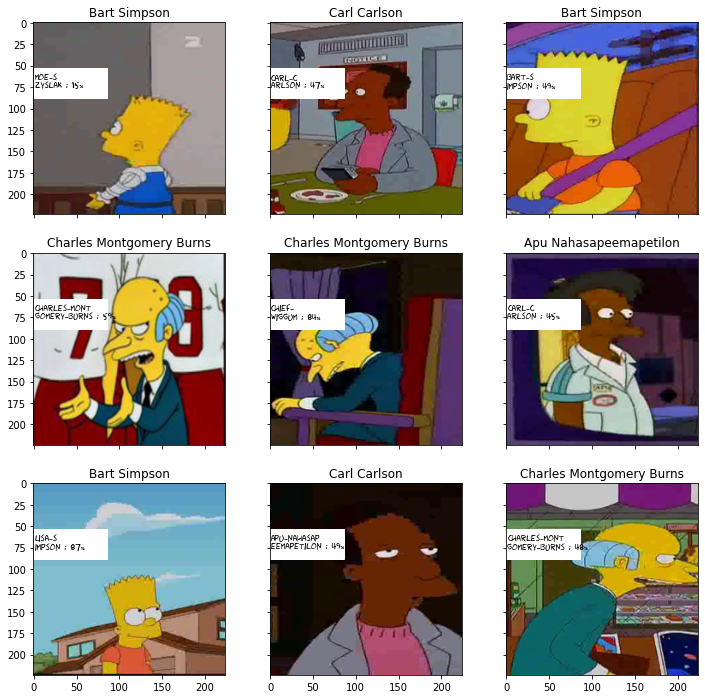

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader) #матрица с вероятностями для каждого класса

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) #вектор в наибольшими вероятностями
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске

In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
# ЗДЕСЬ что-то не работает. Не понятно зачем читайют лейблы 
#import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
#my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
#my_submit.head()

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


***Эксперименты***

1. **Сеть с Batch Norm**

In [24]:
class SimpleCnn_BatchNorm(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [25]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn_BatchNorm(n_classes).to(DEVICE)

In [26]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 1.8452783840098528


epoch:  50%|█████     | 1/2 [02:19<02:19, 139.95s/it]


Epoch 001 train_loss: 1.8453     val_loss 1.3080 train_acc 0.5079 val_acc 0.6496
loss 1.0265421014647171


epoch: 100%|██████████| 2/2 [04:39<00:00, 139.88s/it]


Epoch 002 train_loss: 1.0265     val_loss 1.1626 train_acc 0.7139 val_acc 0.6926


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

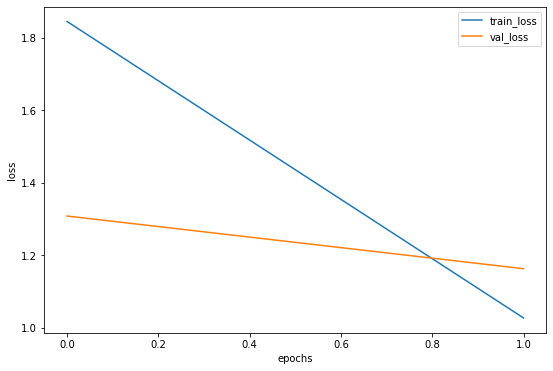

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

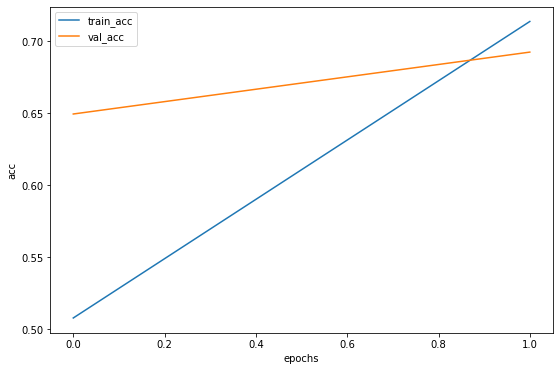

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

С 0.6 до 0.69 только с помощью BatchNorm, неплохо!

**2. Для той же сети увеличим количество эпох и размер батча**

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.6263944963086402


epoch:  20%|██        | 1/5 [02:19<09:17, 139.37s/it]


Epoch 001 train_loss: 0.6264     val_loss 0.8836 train_acc 0.8232 val_acc 0.7642
loss 0.3501995314009684


epoch:  40%|████      | 2/5 [04:35<06:55, 138.37s/it]


Epoch 002 train_loss: 0.3502     val_loss 0.9013 train_acc 0.8988 val_acc 0.7853
loss 0.24429673683347958


epoch:  60%|██████    | 3/5 [06:51<04:35, 137.75s/it]


Epoch 003 train_loss: 0.2443     val_loss 0.9770 train_acc 0.9255 val_acc 0.7801
loss 0.16064713074850562


epoch:  80%|████████  | 4/5 [09:07<02:17, 137.12s/it]


Epoch 004 train_loss: 0.1606     val_loss 1.0500 train_acc 0.9527 val_acc 0.7895
loss 0.12552734927084272


epoch: 100%|██████████| 5/5 [11:22<00:00, 136.48s/it]


Epoch 005 train_loss: 0.1255     val_loss 1.1956 train_acc 0.9597 val_acc 0.7864


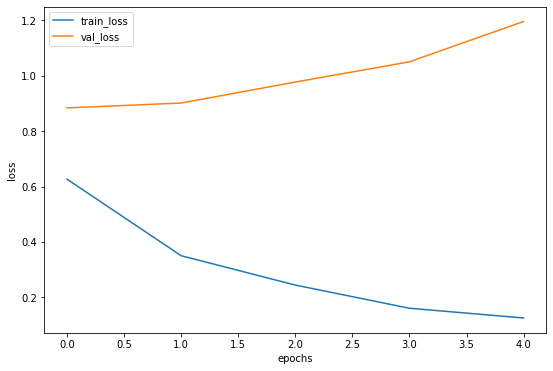

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

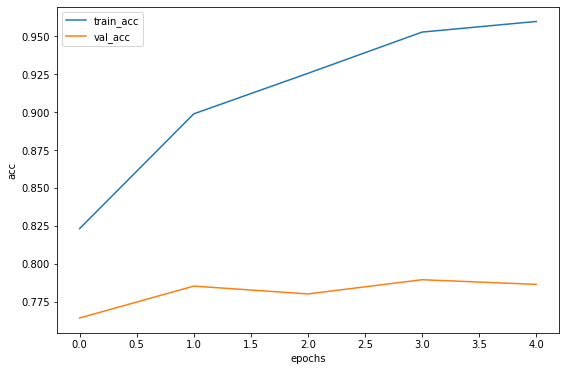

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Точность 78%, что уже лучше предыдущего варианта. Но есть значительное переобучение.

**3. Dropout**

In [27]:
# Сеть с Dropout
class SimpleCnn_Dropout(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [28]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn_Dropout(n_classes).to(DEVICE)

In [30]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=8, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.9897674692991516


epoch:  12%|█▎        | 1/8 [02:24<16:51, 144.50s/it]


Epoch 001 train_loss: 1.9898     val_loss 1.4251 train_acc 0.4746 val_acc 0.6083
loss 1.1061738005746922


epoch:  25%|██▌       | 2/8 [04:49<14:27, 144.65s/it]


Epoch 002 train_loss: 1.1062     val_loss 1.0182 train_acc 0.6947 val_acc 0.7228
loss 0.7279498712698649


epoch:  38%|███▊      | 3/8 [07:09<11:56, 143.23s/it]


Epoch 003 train_loss: 0.7279     val_loss 0.9017 train_acc 0.7974 val_acc 0.7610
loss 0.4893791969015808


epoch:  50%|█████     | 4/8 [09:27<09:27, 141.77s/it]


Epoch 004 train_loss: 0.4894     val_loss 0.8416 train_acc 0.8590 val_acc 0.7837
loss 0.3434105176471268


epoch:  62%|██████▎   | 5/8 [11:47<07:03, 141.16s/it]


Epoch 005 train_loss: 0.3434     val_loss 0.8576 train_acc 0.9012 val_acc 0.7929
loss 0.2140439695742899


epoch:  75%|███████▌  | 6/8 [14:08<04:42, 141.16s/it]


Epoch 006 train_loss: 0.2140     val_loss 0.9108 train_acc 0.9365 val_acc 0.7883
loss 0.15606455450980888


epoch:  88%|████████▊ | 7/8 [16:30<02:21, 141.32s/it]


Epoch 007 train_loss: 0.1561     val_loss 0.9555 train_acc 0.9515 val_acc 0.8034
loss 0.10932394884955283


epoch: 100%|██████████| 8/8 [18:54<00:00, 141.78s/it]


Epoch 008 train_loss: 0.1093     val_loss 0.9447 train_acc 0.9646 val_acc 0.8149


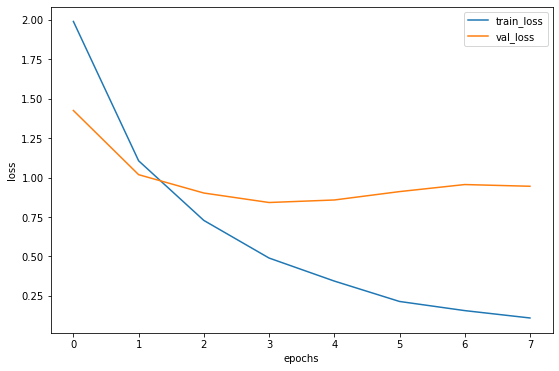

In [31]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

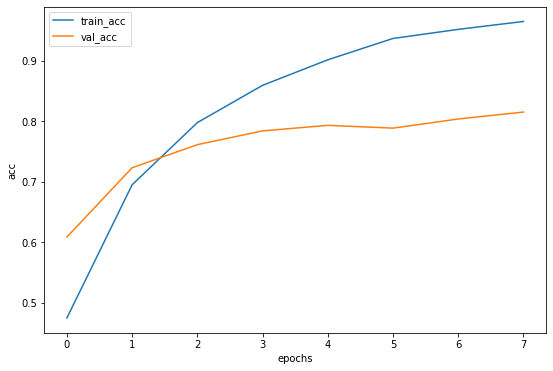

In [32]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Точность около 80%, переобучения уже меньше.

In [33]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [34]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [35]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader) #матрица с вероятностями для каждого класса

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) #вектор в наибольшими вероятностями
test_filenames = [path.name for path in test_dataset.files]


In [39]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline.csv', index=False)
# файл появится у вас на гугл диске

На Kaggle получилось 0.93836, норм))
Upd: Из-за того, что попытки на Каггле закончились, этот вариант оказался там лучшим.

**5. Попробуем аугментацию**

In [ ]:
class SimpsonsDataset_aug(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAutocontrast(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset_aug(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 1.0102271257965374


epoch:  25%|██▌       | 1/4 [03:03<09:11, 183.91s/it]


Epoch 001 train_loss: 1.0102     val_loss 0.8802 train_acc 0.7261 val_acc 0.7830
loss 0.6252868115480511


epoch:  50%|█████     | 2/4 [06:07<06:07, 183.91s/it]


Epoch 002 train_loss: 0.6253     val_loss 0.8237 train_acc 0.8265 val_acc 0.8021
loss 0.5101989606503688


epoch:  75%|███████▌  | 3/4 [09:10<03:03, 183.52s/it]


Epoch 003 train_loss: 0.5102     val_loss 0.8029 train_acc 0.8581 val_acc 0.8021
loss 0.41571148169390737


epoch: 100%|██████████| 4/4 [12:13<00:00, 183.35s/it]


Epoch 004 train_loss: 0.4157     val_loss 0.8109 train_acc 0.8837 val_acc 0.8181


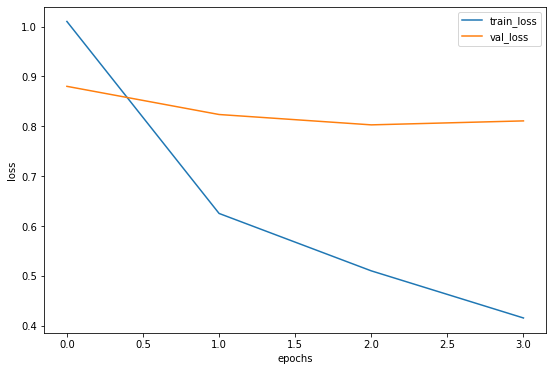

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

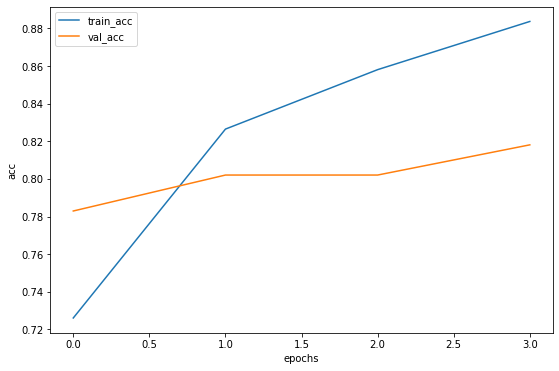

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

81% с аугментацией данных, ок

**6. Надо сбалансировать классы**

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)
# Посмотрим, что у нас получилось.
print_dct(dct_path_train)

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0895.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0830.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0462.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0068.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0468.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0800.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0470.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0644.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0086.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0765.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0794.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0406.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0647.jpg'), PosixPath('train/simpsons_d

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn_Dropout(n_classes).to(DEVICE)

In [ ]:
history = train(new_train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 2.5311019965604395


epoch:  25%|██▌       | 1/4 [03:10<09:30, 190.28s/it]


Epoch 001 train_loss: 2.5311     val_loss 1.6885 train_acc 0.3347 val_acc 0.5405
loss 1.49623760552731


epoch:  50%|█████     | 2/4 [06:18<06:19, 189.76s/it]


Epoch 002 train_loss: 1.4962     val_loss 1.1845 train_acc 0.5928 val_acc 0.6737
loss 1.0867459537671762


epoch:  75%|███████▌  | 3/4 [09:26<03:09, 189.14s/it]


Epoch 003 train_loss: 1.0867     val_loss 0.9128 train_acc 0.7027 val_acc 0.7488
loss 0.8486189304533198


epoch: 100%|██████████| 4/4 [12:35<00:00, 188.79s/it]


Epoch 004 train_loss: 0.8486     val_loss 0.7816 train_acc 0.7640 val_acc 0.7908


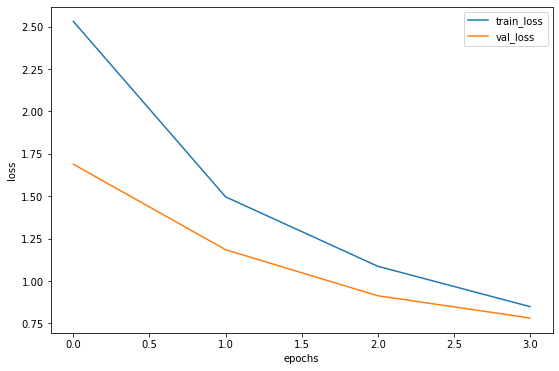

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

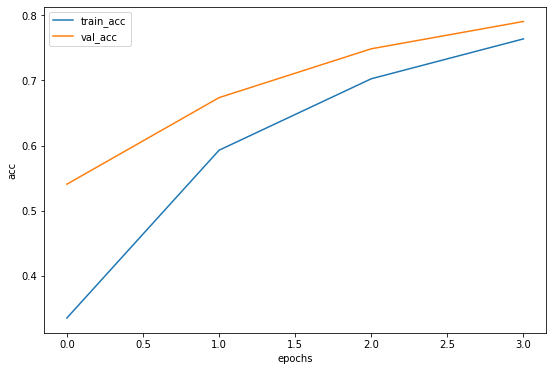

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Ну... графики кросевые, но результат не впечатляет (

**7. Все вместе: Batch Norm + Dropout + Балансировка классов + Аугментация данных**

In [53]:
class SimpsonsDataset_aug(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAutocontrast(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [54]:
# Сеть с Dropout
class SimpleCnn_Dropout(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [55]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [56]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [57]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [58]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)
# Посмотрим, что у нас получилось.
#print_dct(dct_path_train)

In [59]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [60]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [61]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset_aug(new_train_files, mode='train')

In [62]:
# определим загрузщики данных без взвешивания классов для их балансировки простой вариант
BATCH_SIZE = 128
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [63]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn_Dropout(n_classes).to(DEVICE)

In [64]:
history = train(new_train_dataset, val_dataset, model=simple_cnn, epochs=8, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.193000658134479


epoch:  12%|█▎        | 1/8 [02:24<16:49, 144.21s/it]


Epoch 001 train_loss: 2.1930     val_loss 1.3842 train_acc 0.4178 val_acc 0.6204
loss 1.1635585377509294


epoch:  25%|██▌       | 2/8 [04:49<14:28, 144.68s/it]


Epoch 002 train_loss: 1.1636     val_loss 0.8884 train_acc 0.6812 val_acc 0.7564
loss 0.7744254731958827


epoch:  38%|███▊      | 3/8 [07:13<12:01, 144.37s/it]


Epoch 003 train_loss: 0.7744     val_loss 0.6429 train_acc 0.7822 val_acc 0.8219
loss 0.5314327872773706


epoch:  50%|█████     | 4/8 [09:37<09:37, 144.28s/it]


Epoch 004 train_loss: 0.5314     val_loss 0.4986 train_acc 0.8476 val_acc 0.8651
loss 0.3704181160412136


epoch:  62%|██████▎   | 5/8 [12:01<07:12, 144.23s/it]


Epoch 005 train_loss: 0.3704     val_loss 0.3691 train_acc 0.8902 val_acc 0.9006
loss 0.24137769908394446


epoch:  75%|███████▌  | 6/8 [14:20<04:44, 142.46s/it]


Epoch 006 train_loss: 0.2414     val_loss 0.3195 train_acc 0.9271 val_acc 0.9219
loss 0.1624881411477315


epoch:  88%|████████▊ | 7/8 [16:37<02:20, 140.90s/it]


Epoch 007 train_loss: 0.1625     val_loss 0.2924 train_acc 0.9501 val_acc 0.9326
loss 0.1377352891955317


epoch: 100%|██████████| 8/8 [18:57<00:00, 142.16s/it]


Epoch 008 train_loss: 0.1377     val_loss 0.2965 train_acc 0.9568 val_acc 0.9287


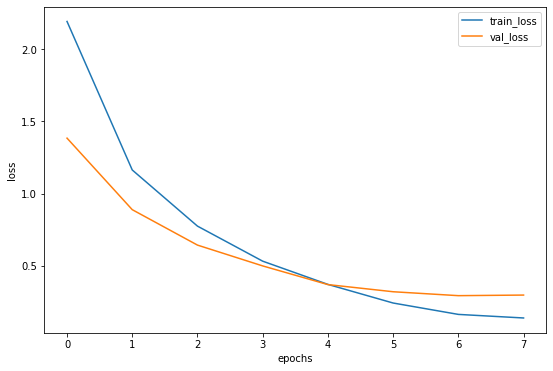

In [65]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

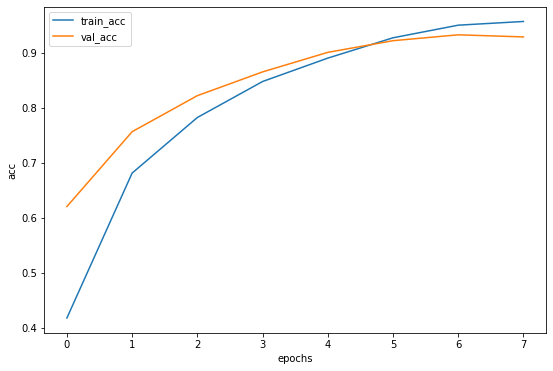

In [66]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

93%, лучший результат!

In [67]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [68]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [69]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [70]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [71]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [73]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader) #матрица с вероятностями для каждого класса

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) #вектор в наибольшими вероятностями
test_filenames = [path.name for path in test_dataset.files]


In [75]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baseline2.csv', index=False)
# файл появится у вас на гугл диске

На Kaggle получилось 0.92561, и это печально, попытки закончились(((((

**8. AlexNet FineTuning**

In [ ]:
from torchvision import models
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
alexnet.classifier = nn.Linear(num_features, n_classes)

# Использовать ли GPU
alexnet = alexnet.cuda()

# В качестве cost function используем кросс-энтропию
#loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
#optimizer_ft = optim.Adam(inception.parameters(), lr=3e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=alexnet, epochs=4, batch_size=128)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 2.2556657984162736


epoch:  25%|██▌       | 1/4 [03:23<10:11, 203.94s/it]


Epoch 001 train_loss: 2.2557     val_loss 1.4348 train_acc 0.3774 val_acc 0.6022
loss 1.0099830631769662


epoch:  50%|█████     | 2/4 [06:50<06:49, 204.70s/it]


Epoch 002 train_loss: 1.0100     val_loss 0.8788 train_acc 0.7278 val_acc 0.7686
loss 0.5829730821161545


epoch:  75%|███████▌  | 3/4 [10:17<03:25, 205.33s/it]


Epoch 003 train_loss: 0.5830     val_loss 0.7108 train_acc 0.8376 val_acc 0.8170
loss 0.3922841931362882


epoch: 100%|██████████| 4/4 [13:40<00:00, 205.17s/it]


Epoch 004 train_loss: 0.3923     val_loss 0.6420 train_acc 0.8894 val_acc 0.8414


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

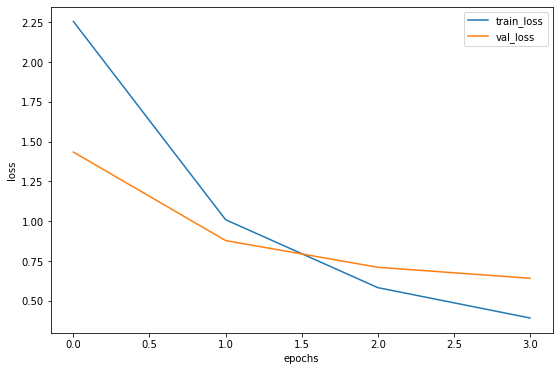

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

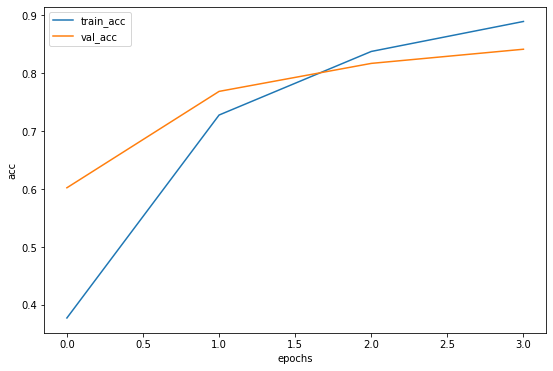

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

84% и чувствуется, что есть потенциал к улучшениям при увеличении количества эпох.
Попробуем Feature Extractor, а также увеличить количество эпох

**9. AlexNet Feature Extractor**

In [ ]:
from torchvision import models
alexnet_extractor = models.alexnet(pretrained=True)

In [ ]:
# замораживаем параметры (веса)
for param in alexnet_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
alexnet_extractor.classifier = nn.Linear(num_features, n_classes)

# Использовать ли GPU
alexnet_extractor = alexnet_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(alexnet_extractor.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 4 эпохи 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=alexnet_extractor, epochs=8, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 2.0273212633912627


epoch:  12%|█▎        | 1/8 [03:02<21:13, 181.99s/it]


Epoch 001 train_loss: 2.0273     val_loss 1.0466 train_acc 0.6279 val_acc 0.7633
loss 0.3409859642962588


epoch:  25%|██▌       | 2/8 [06:05<18:14, 182.37s/it]


Epoch 002 train_loss: 0.3410     val_loss 0.9988 train_acc 0.9013 val_acc 0.7810
loss 0.12688934022973727


epoch:  38%|███▊      | 3/8 [09:13<15:20, 184.15s/it]


Epoch 003 train_loss: 0.1269     val_loss 0.8627 train_acc 0.9649 val_acc 0.8166
loss 0.054104812647329865


epoch:  50%|█████     | 4/8 [12:26<12:27, 186.84s/it]


Epoch 004 train_loss: 0.0541     val_loss 0.8501 train_acc 0.9904 val_acc 0.8202
loss 0.023838543327833386


epoch:  62%|██████▎   | 5/8 [15:33<09:20, 186.87s/it]


Epoch 005 train_loss: 0.0238     val_loss 0.8417 train_acc 0.9987 val_acc 0.8277
loss 0.014543966547400282


epoch:  75%|███████▌  | 6/8 [18:34<06:09, 184.93s/it]


Epoch 006 train_loss: 0.0145     val_loss 0.8359 train_acc 0.9997 val_acc 0.8298
loss 0.009695223934179134


epoch:  88%|████████▊ | 7/8 [21:33<03:03, 183.22s/it]


Epoch 007 train_loss: 0.0097     val_loss 0.8372 train_acc 0.9999 val_acc 0.8298
loss 0.008986438776014207


epoch: 100%|██████████| 8/8 [24:33<00:00, 184.23s/it]


Epoch 008 train_loss: 0.0090     val_loss 0.8506 train_acc 0.9999 val_acc 0.8284


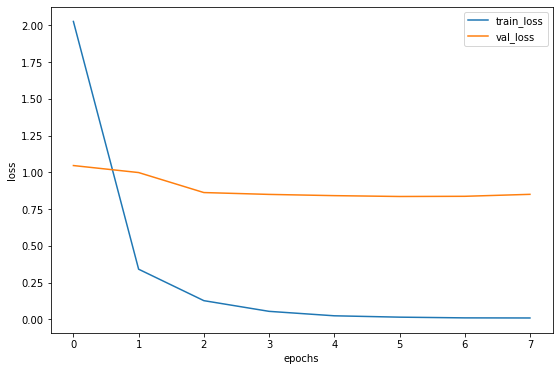

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

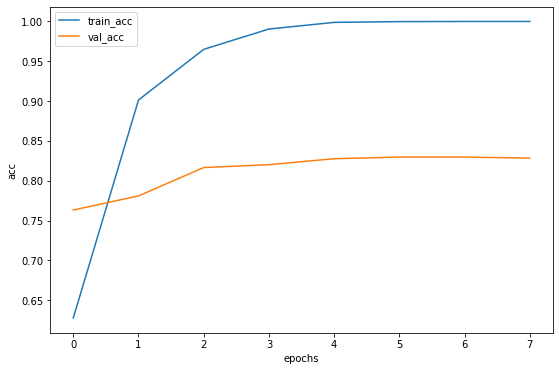

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

82%, есть значительное переобучение модели

**10. Mixed Alexnet**

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
from torchvision import models
alexnet_mixed = models.alexnet(pretrained=True)

In [ ]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in alexnet_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
alexnet_mixed.classifier = nn.Linear(num_features, n_classes)

# Использовать ли GPU
alexnet_mixed = alexnet_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(alexnet_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(alexnet_mixed.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train(train_dataset, val_dataset, model=alexnet_mixed, epochs=4, batch_size=128)
loss, acc, val_loss, val_acc = zip(*history)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 1.5338191531666923


epoch:  25%|██▌       | 1/4 [04:46<14:18, 286.29s/it]


Epoch 001 train_loss: 1.5338     val_loss 0.7648 train_acc 0.6008 val_acc 0.8066
loss 0.4933463035990903


epoch:  50%|█████     | 2/4 [09:34<09:33, 286.99s/it]


Epoch 002 train_loss: 0.4933     val_loss 0.5669 train_acc 0.8690 val_acc 0.8544
loss 0.2922635177336137


epoch:  75%|███████▌  | 3/4 [14:22<04:47, 287.18s/it]


Epoch 003 train_loss: 0.2923     val_loss 0.5520 train_acc 0.9210 val_acc 0.8749
loss 0.2008837320441923


epoch: 100%|██████████| 4/4 [19:10<00:00, 287.53s/it]


Epoch 004 train_loss: 0.2009     val_loss 0.6337 train_acc 0.9443 val_acc 0.8626


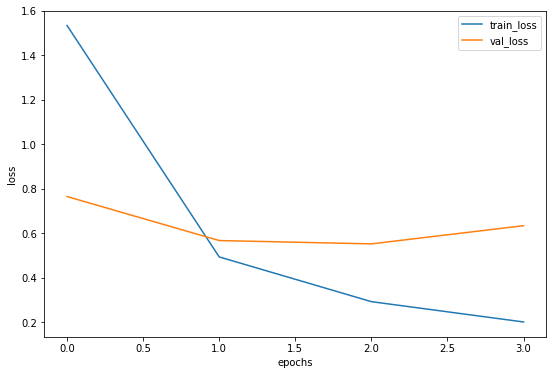

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

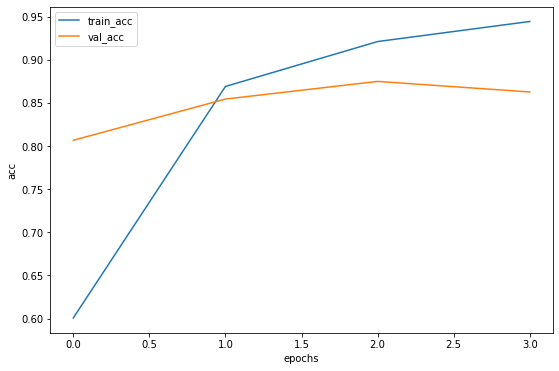

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

86%, пока что лучший результат для Алекснета